In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math as M


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/Users/flywire/Desktop/sci/dihiggsMLProject/')
from utils.commonFunctions import *

In [2]:
def trainBDT(X, y, X_val, y_val, param):

    evallist = [(X, y), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)
    results = model.evals_result()
    ypred = model.predict(X_val)
    predictions = [round(value) for value in ypred]
    accuracy = accuracy_score(y_val, predictions)
    print("The training accuaracy is: {}".format(accuracy))
    conf_matrix = confusion_matrix(y_val, predictions)
    print("The confusion matrix: {}".format(conf_matrix))
    print("The precision is: {}".format(precision_score(y_val, predictions)))
    print("The eval_result is: {}".format(model.get_booster().best_iteration))
    print("The eval_result is: {}".format(model.get_booster().best_score))
    plot_BDTScore(X_val.copy(), y_val.copy(), model)
    return


def plot_BDTScore(X_val, y_val, model):
    sig_index = np.asarray(np.where(y_val==1))[0,:]
    bkg_index = np.asarray(np.where(y_val==0))[0,:]
    X_sig = X_val[sig_index,:]
    X_bkg = X_val[bkg_index,:]
    pred_sig = model.predict_proba(X_sig)[:,1]
    pred_bkg = model.predict_proba(X_bkg)[:,1]
    returnBestCutValue('BDT',pred_sig.copy(), pred_bkg.copy(), _testingFraction=0.3)
    plt.hist(pred_sig, bins=100, alpha=0.5, density=True, label="signal")
    plt.hist(pred_bkg, bins=100, alpha=0.5, density=True, label="background")
    plt.legend(loc="best")
    plt.title("BDT score")
    plt.show()
    
    
def plot_learning_curve(X, y, param, nClus):
    train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(**param), X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")
    plt.legend(loc="best")
    plt.title("{} clusters learning curve".format(nClus))
    plt.show()
    
def plotCostFunc_kClus(data, nClus):
    #find out the "best" value of n_clusters to perform k-means clustering
    cost = []
    for i in range(1,nClus+1):
        ki = KMeans(n_clusters=i, random_state=0).fit(data)
        cost.append(ki.inertia_)
    plt.plot(range(1,nClus+1),cost, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('cost function')
    plt.show()
    

def KClustering(X, y, X_test, y_test, nClusters, usePCA, n_vars):
    if(usePCA):
        #process data with PCA
        #find the number of features that keep 95% variance
        print("Doing PCA...")
        variance_threshold = 0.95
        num_components = n_vars
        pca_trail = PCA()
        pca_trail.fit(X)
        var = np.cumsum(pca_trail.explained_variance_ratio_)
        for n_com in range(1,len(var)-1):
            if(var[n_com]>variance_threshold):
                num_components = n_com
                break

        print("Doing k-means clustering with {0} features...".format(num_components))
        pca = PCA(n_components=num_components)
        pca.fit(X)
        X_train_pca = pca.transform(X)
        X_test_pca = pca.transform(X_test)
        print("Shape of new training dataset: {}".format(X_train_pca.shape))
        print("Shape of new testing dataset: {}".format(X_test_pca.shape))
        #do the k-means clustering
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X_train_pca)
        score_train = kmeans.transform(X_train_pca)
        score_test = kmeans.transform(X_test_pca)
    else:
        #do k-means clustering
        print("Doing k-means clustering...")
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X)
        score_train = kmeans.transform(X)
        score_test = kmeans.transform(X_test)
        
    score_train_norm = scale(score_train)
    score_test_norm = scale(score_test)
    y_np = y.to_numpy()
    y_test_np = y_test.to_numpy()
    print("Finished clustering. :)")
    
    return score_train_norm, y_np, score_test_norm, y_test_np

def trainBDT_pyswarm(X_train, y_train, X_val, y_val, param):
    evallist = [(X_train, y_train), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train.ravel(), eval_set=evallist, verbose=False, early_stopping_rounds=30)
    best_score = 1.0-model.get_booster().best_score
    return best_score

def f_BDT(x,data,labels,param_list):
    # *** 1. split our data set to training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, shuffle=True, random_state=7)
    n_particles = x.shape[0]
    BDT_result = []    #used to store the BDT training results for each particle
    for i in range (n_particles):
        # *** 2. set hyper parameters
        param = {
            'n_jobs': -1,
            'eta': 0.3,
            'n_estimators': 5000,
            'max_depth': 7,
            'min_child_weight': 2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0,
            #'reg_alpha': x[i,5], 
            #'reg_lambda': x[i,6],
            'scale_pos_weight': 1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'random_state': 27
        }
        for n_param in range (len(param_list)):
            if(param_list[n_param]=='max_depth'):
                param[param_list[n_param]] = int(x[i,n_param]*7+2)
            else:
                param[param_list[n_param]] = x[i,n_param]
            
        BDT_result.append(trainBDT_pyswarm(X_train, y_train, X_val, y_val, param))
    return np.array(BDT_result)



In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()


# *** 2. Make mix of dihiggs and QCD for specified variables
#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables = ['hh_mass', 'h1_mass', 'h2_mass']
variables = list(qcd_raw.columns.values)
variables.remove('isSignal')
variables.remove('isMatchable')
remove_list = []
for var in variables:
    if((var.find('gen')!=-1) or (var.find('reco')!=-1) or ( (var.find('jet')!=-1) and (var.find('_')!=-1) ) ):
        remove_list.append(var)
#print(remove_list)
for r_var in remove_list:        
    variables.remove(r_var)
    
print(variables)

data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables, testingFraction)

data_train_norm = scale(data_train)
data_test_norm = scale(data_test)


['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [4]:
# *** Do the k-means clustering
#nClus = 40    # can try 15 20 40
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, False, len(variables))
#score_pcakm_train_norm,labels_train_np,score_pcakm_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
score_km_train_norm = data_train_norm
labels_train_np = labels_train.to_numpy()
score_km_test_norm = data_test_norm
labels_test_np = labels_test.to_numpy()

In [5]:
from pyswarms.single.global_best import GlobalBestPSO
# *** pyswarm process
# *** 1. set the name, max and min bound of parameters
param_name = ['reg_alpha','min_child_weight']
n_dimensions = len(param_name)
param_max_list = [50,5]
param_min_list = [1e-05,0]
#param_max_list = [1,5,1,1,1.5,50,10]
#param_min_list = [0,0,0,0,0,1e-05,0]
param_max = np.array(param_max_list)
param_min = np.array(param_min_list)
bounds = (param_min, param_max)
# *** 2. set options
#options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} # can use grid search to get a better value of those parameters
#options = {'c1': 2.05, 'c2': 2.05, 'w': 0.7} # try this afterwards
options = {'c1': 0.8, 'c2': 0.6, 'w': 0.35} 
optimizer = GlobalBestPSO(n_particles=5, dimensions=n_dimensions, options=options, bounds=bounds)
cost, pos = optimizer.optimize(f_BDT, iters=50, data=score_km_train_norm, labels=labels_train_np, param_list=param_name, n_processes=4)



2020-01-09 11:44:05,052 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.8, 'c2': 0.6, 'w': 0.35}
pyswarms.single.global_best:   0%|          |0/50/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/prepr

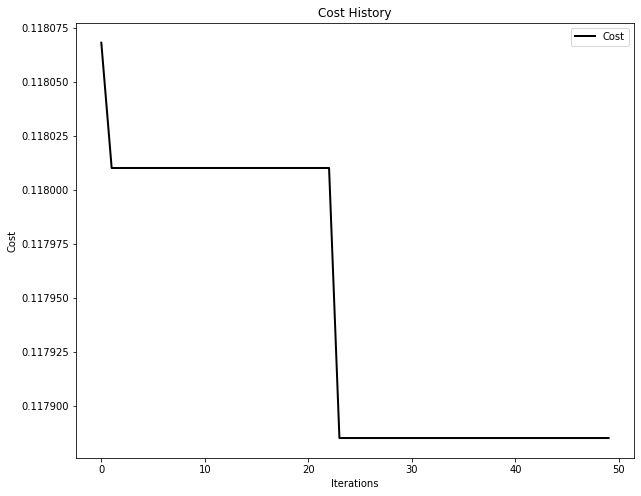

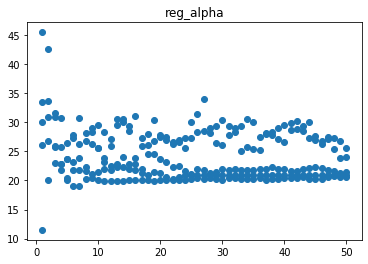

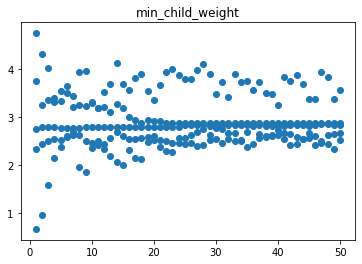

In [16]:
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()
parameter_name = param_name
#parameter_name = ['max_depth','min_child_weight','subsample','colsample_bytree','gamma','reg_alpha','reg_lambda']
n_iters = len(optimizer.pos_history) #number of iterations PSO went through
#n_dimensions = 7 #number of parameters to tune
n_particles = len(optimizer.pos_history[0]) #number of particles
y_plot = np.zeros((n_dimensions,n_particles*n_iters))
x_plot = np.zeros((n_dimensions,n_particles*n_iters))
plots = []
for i in range (0,n_iters):
    a = optimizer.pos_history[i]
    for d in range(0,n_dimensions):
        x_plot[d,i*n_particles:(i+1)*n_particles] = i+1
        if parameter_name[d]=='max_depth': #d==0 means max_depth, which is normalized
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]*7+2
        else:
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]
for nd in range (0,n_dimensions):
    if parameter_name[nd]=='max_depth':
        plt.scatter(x_plot[nd,:],(y_plot[nd,:]*7+2))
    else:
        plt.scatter(x_plot[nd,:],y_plot[nd,:])
    plt.title(parameter_name[nd])
    plt.show()
    




2020-01-09 16:06:37,895 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
2020-01-09 16:06:37,896 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


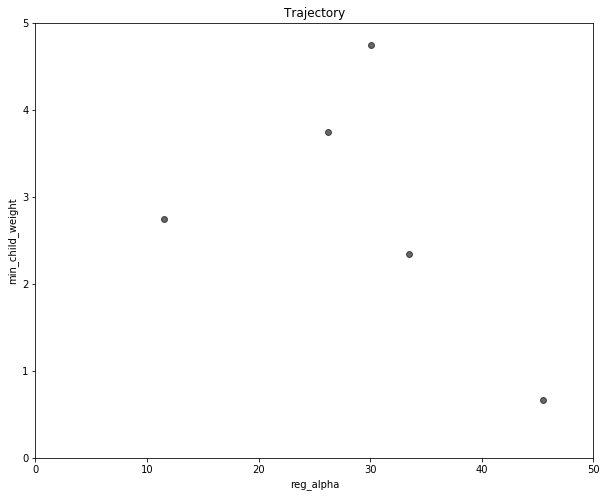

In [21]:
from IPython.display import Image
from pyswarms.utils.plotters.formatters import Mesher, Designer
d = Designer(limits=[(0,50), (0,5)],
             label=['reg_alpha', 'min_child_weight'])
animation = plot_contour(pos_history=optimizer.pos_history, designer=d)
animation.save('plot0.gif', writer='imagemagick', fps=1)
Image(url='plot0.gif')



In [8]:
import time
time.ctime()

'Thu Jan  9 15:41:21 2020'

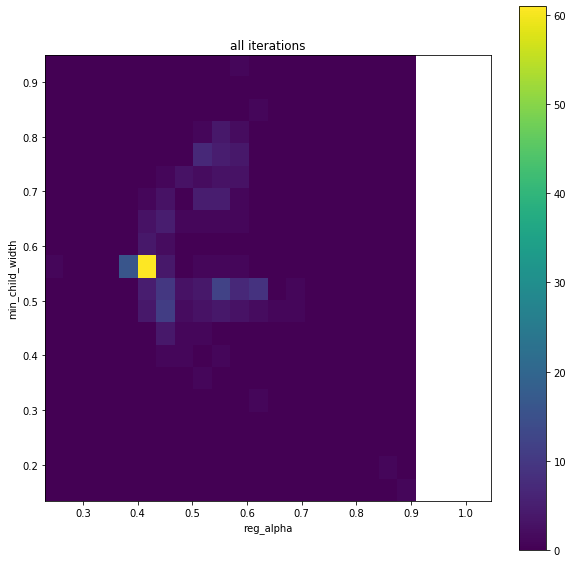

In [42]:
pts = optimizer.pos_history[0]
for i in range (1,10):
    pts = np.vstack((pts,optimizer.pos_history[i]))

heatmap, xedges, yedges = np.histogram2d(pts[:,0]/50.0, pts[:,1]/5.0, bins=(20,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(10,10))
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.title("first 10 iterations")
plt.xlabel("reg_alpha")
plt.ylabel("min_child_width")
plt.axis('square')
#plt.axis('equal')
plt.colorbar()
plt.show()
#plt.axis('square')

In [44]:
optimizer.pos_history

[array([[0.60054892, 4.7506475 ],
        [0.23030288, 2.7424496 ],
        [0.90912837, 0.66584723],
        [0.52341258, 3.7520493 ],
        [0.66901324, 2.3387643 ]]), array([[0.74394328, 0.09418362],
        [0.97246926, 0.22933364],
        [0.9027998 , 1.2643383 ],
        [0.07605523, 0.42406551],
        [0.99625809, 0.97406698]]), array([[0.31609217, 3.10513402],
        [0.25659585, 1.2615241 ],
        [0.43871066, 0.15544283],
        [0.49503402, 1.08893733],
        [0.39300236, 2.16600658]]), array([[0.57989469, 3.28029535],
        [0.14178624, 0.10779538],
        [0.96327552, 3.54851416],
        [0.68746063, 3.18689403],
        [0.53537817, 0.22977583]]), array([[0.7870984 , 1.64648621],
        [0.65479366, 2.19141833],
        [0.7144418 , 1.74463376],
        [0.49932728, 0.8941541 ],
        [0.72506173, 3.91910448]]), array([[0.78177868, 1.73988875],
        [0.42319598, 3.53995115],
        [0.87432074, 2.03858765],
        [0.44847365, 4.8653535 ],
        [

In [54]:
from pyswarms.single.global_best import GlobalBestPSO
# *** pyswarm process
# *** 1. set the name, max and min bound of parameters
param_name = ['max_depth','min_child_weight']
n_dimensions = len(param_name)
param_max_list = [1,5]
param_min_list = [0,0]
#param_max_list = [1,5,1,1,1.5,50,10]
#param_min_list = [0,0,0,0,0,1e-05,0]
param_max = np.array(param_max_list)
param_min = np.array(param_min_list)
bounds = (param_min, param_max)
# *** 2. set options
#options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} # can use grid search to get a better value of those parameters
options = {'c1': 1.025, 'c2': 1.025, 'w': 0.35} # try this afterwards
optimizer = GlobalBestPSO(n_particles=2, dimensions=n_dimensions, options=options, bounds=bounds)
cost, pos = optimizer.optimize(f_BDT, iters=5, data=score_km_train_norm, labels=labels_train_np, param_list=param_name)



2020-01-08 21:11:53,171 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.025, 'c2': 1.025, 'w': 0.35}
pyswarms.single.global_best:   0%|          |0/5/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0.121
2020-01-08 21:28:12,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.12065700000000001, best pos: [0.85378159 1.45890665]


2020-01-08 21:28:59,543 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
2020-01-08 21:28:59,544 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


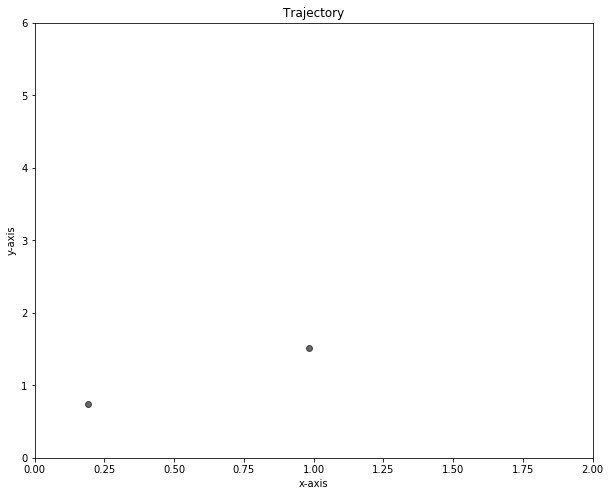

In [55]:
from IPython.display import Image
from pyswarms.utils.plotters.formatters import Mesher, Designer
d = Designer(limits=[(0,2), (0,6)],
             label=['x-axis', 'y-axis'])
animation = plot_contour(pos_history=optimizer.pos_history, designer=d)
animation.save('plot0.gif', writer='imagemagick', fps=5)
Image(url='plot0.gif')

